In [1092]:
import pandas as pd
import numpy as np
import os
import requests
from collections import Counter
from itertools import combinations
from bs4 import BeautifulSoup
from sklearn.neighbors import DistanceMetric
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain, combinations

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.cluster import contingency_matrix
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import scipy.stats as st
from sklearn.inspection import permutation_importance

dist = DistanceMetric.get_metric('haversine')

powerset = lambda s: [list(x)
                      for x in list(chain.from_iterable(combinations(s, r) 
                                                        for r in range(len(s)+1)))[1::]]


def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

## to-do:

- same thing but with classes from ids!
- remove the doubling coordinates to avoid comparing identical varieties and thus having good predictions in the case when lgs are identical varieties
- **NB**: *The communicative lexicon hypothesis* by Piantadosi


In [686]:
forms = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'intercontinental-dictionary-series-ids-8f40d29/cldf/forms.csv')
params = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'intercontinental-dictionary-series-ids-8f40d29/cldf/parameters.csv')
languages = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'intercontinental-dictionary-series-ids-8f40d29/cldf/languages.csv')
complete = pd.merge(left=forms.set_index('Parameter_ID'),
                    right=params.set_index('ID'),
                    left_index=True, right_index=True)
complete_ids = pd.merge(left=complete.set_index('Language_ID'),
                        right=languages.set_index('ID'), left_index=True,
                        right_index=True)
complete_ids = complete_ids.dropna(subset=['Latitude', 'Longitude'])
complete_ids = complete_ids.dropna(subset=['Concepticon_Gloss'])
complete_ids.head(4)
complete_ids.to_csv('ids.csv')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (7,8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [687]:
lgs_wd = complete_ids[['Name_y', 'Latitude', 'Longitude']].groupby('Name_y')\
.max().drop_duplicates(subset=['Latitude', 'Longitude']).index.values

len(lgs_wd)

245

In [688]:
complete_ids = complete_ids[complete_ids['Name_y'].isin(lgs_wd)]

In [689]:
len(complete_ids.Name_y.unique())

245

In [690]:
status_dict = {}

for element in complete_ids.Glottocode.unique():
    soup = BeautifulSoup(requests.get('https://glottolog.org/resource/languoid/id/{}'.format(element)).content)
    try:
        status_dict[element] = soup.select('.dl-horizontal > dd:nth-child(2)')[0].text
    except IndexError:
        status_dict[element] = np.nan

In [691]:
complete_ids['Status'] = complete_ids['Glottocode'].map(status_dict)

In [692]:
complete_ids = complete_ids[complete_ids['Status'] != 'extinct']

In [693]:
len(complete_ids.Name_y.unique())

220

<AxesSubplot:ylabel='Frequency'>

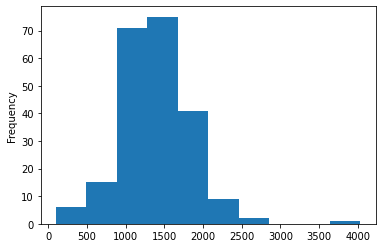

In [694]:
complete_ids[['Name_y', 'Glottolog_Name']].groupby('Name_y').size().plot.hist()

In [695]:
complete_ids[['Name_y',
              'Latitude', 
              'Longitude',
              'Family']].drop_duplicates().to_csv('coords.csv')

In [697]:
len(complete_ids.Family.unique())

56

In [698]:
complete_ids.to_csv('ids.csv')

## 1. Pre-processing

In [699]:
def get_colex_lang(language, dataframe, conc=None):
    if not conc:
        conc = dataframe[dataframe['Name_y'] == language][
            'Concepticon_Gloss'].unique()
    conc_matrix = pd.DataFrame(np.zeros((len(conc), len(conc))), columns=conc,
                               index=conc)
    lang_df = dataframe[(dataframe['Concepticon_Gloss'].isin(conc)) & (
                dataframe['Name_y'] == language)]
    d = dict()
    for i, values in lang_df[['Form', 'Concepticon_Gloss']].iterrows():
        if values['Form'] not in d.keys():
            d[values['Form']] = [values['Concepticon_Gloss']]
        else:
            d[values['Form']].append(values['Concepticon_Gloss'])
    colex_values = []
    for i, j in d.items():
        if len(j) == 2:
            if j[0] != j[1]:
                conc_matrix.at[[j[0]], [j[1]]] = 1
                conc_matrix.at[[j[1]], [j[0]]] = 1
                colex_values += [j]
        elif len(j) > 2:
            for comb in [_ for _ in combinations(j, 2)]:
                if comb[0] != comb[1]:
                    conc_matrix.at[[comb[0]], [comb[1]]] = 1
                    conc_matrix.at[[comb[1]], [comb[0]]] = 1
                    colex_values += [comb]
    colex_values_r = []
    for pair in colex_values:
        colex_values_r.append(pair[::-1])
    return conc_matrix.values, colex_values

In [700]:
initial = complete_ids

concepts_2 = {}

for language in initial['Name_y'].unique():
    concepts_2[language] = list(initial[initial['Name_y'] 
                                        == language]['Concepticon_Gloss'].unique())
        
    colex_global = []

for lang in initial['Name_y'].unique():
    colex_global += ['{} + {}'.format(i[0], i[1]) 
                     for i in get_colex_lang(lang, 
                                             initial, 
                                             concepts_2.get(lang))[1]]

C = Counter(colex_global)
total = len(initial['Name_y'].unique())
for key in C:
    C[key] /= total

In [701]:
print(C.most_common(10))

[('KNIFE (FOR EATING) + KNIFE', 0.8045454545454546), ('SON-IN-LAW (OF MAN) + SON-IN-LAW (OF WOMAN)', 0.7681818181818182), ('DAUGHTER-IN-LAW (OF MAN) + DAUGHTER-IN-LAW (OF WOMAN)', 0.7454545454545455), ('HIGH + TALL', 0.5954545454545455), ('HOW MANY PIECES + HOW MUCH', 0.5954545454545455), ('SKIN + LEATHER', 0.5818181818181818), ('MOON + MONTH', 0.55), ('FATHER-IN-LAW (OF MAN) + FATHER-IN-LAW (OF WOMAN)', 0.55), ('MOTHER-IN-LAW (OF MAN) + MOTHER-IN-LAW (OF WOMAN)', 0.55), ('FLESH + MEAT', 0.5181818181818182)]


## 2. NPM computation

In [702]:
def get_distance(df, heatmap=False):
    df = df.copy()
    df['Latitude'] = np.radians(df['Latitude'])
    df['Longitude'] = np.radians(df['Longitude'])
    dist_km = pd.DataFrame(dist.pairwise(df.
                                         drop_duplicates(subset='Name_y')[
                                             ['Latitude', 'Longitude']].
                                         to_numpy()) * 6373,
                           columns=df['Name_y'].unique(),
                           index=df['Name_y'].unique())
    if heatmap:
        plt.figure(figsize=(10, 10))
        sns.heatmap(dist_km, cmap="YlGnBu", xticklabels=False,
                    yticklabels=False, cbar=False)
    return dist_km

In [703]:
distance_m = get_distance(complete_ids)

In [704]:
distance_m.to_csv('distance_ids.csv')

In [705]:
all_colex_langs = []
all_colex = []

for lang in complete_ids.Glottolog_Name.unique():
    all_colex += ['{} + {}'.format(i[0], i[1]) 
                     for i in get_colex_lang(lang,
                                             complete_ids)[1]]
    all_colex_langs.append((lang, ['{} + {}'.format(i[0], i[1]) 
                                   for i in get_colex_lang(lang, 
                                                           complete_ids)[1]]))
c_colex = Counter(all_colex)

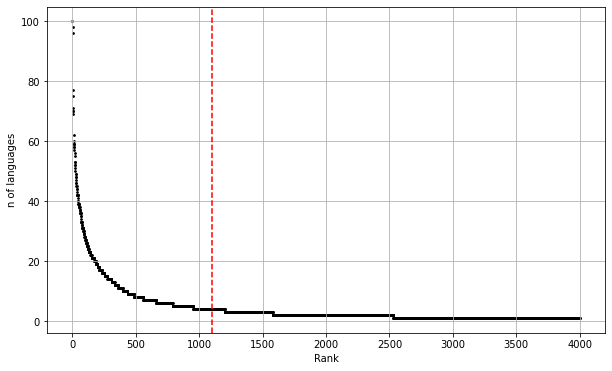

In [706]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter([_ for _ in range(1, 8000)], 
            [(i[1]) for i in c_colex.most_common(8000)], 
            alpha=1, 
            color='black', s=3)
plt.axvline(x=1098, linestyle='--', color='red')
plt.xlabel('Rank')
plt.ylabel('n of languages')
plt.savefig('figures/fig3.pdf', dpi=300)
# plt.yscale('log',base=10)
# plt.xscale('log',base=10)

In [707]:
colex_df = pd.DataFrame(columns=list(c_colex), index=complete_ids.Name_y.unique())
colex_df = colex_df.fillna(0)

for lang in all_colex_langs:
    for colexification in lang[1]:
        colex_df[colexification][lang[0]] = 1

In [708]:
distance_m = distance_m.mask(distance_m <= 1500, 1)
distance_m = distance_m.mask(distance_m > 1500, 0)
G = nx.from_pandas_adjacency(distance_m)
label_mapping = {idx: val for idx, val in enumerate(distance_m.columns)}
G = nx.relabel_nodes(G, label_mapping)

In [709]:
df = complete_ids[['Name_y', 'Family']].drop_duplicates()
family_dict = dict(zip(df.Name_y, df.Family))

In [710]:
def NPM(lang, feature):
    res = []
    for lang_ in colex_df.index[colex_df[feature] == 1].tolist():
        try:
            res.append(1/2**len(nx.shortest_path(G, source=lang, target=lang_)))
        except:
            pass
    return sum(res)

In [711]:
def NPM_nsf(lang, feature):
    res = []
    for lang_ in colex_df.index[colex_df[feature] == 1].tolist():
        if family_dict.get(lang_) != family_dict.get(lang):
            try:
                res.append(1/2**len(nx.shortest_path(G, source=lang, target=lang_)))
            except:
                pass
    return sum(res)

In [712]:
def NPM_sf(lang, feature):
    res = []
    for lang_ in colex_df.index[colex_df[feature] == 1].tolist():
        if family_dict.get(lang_) == family_dict.get(lang):
            try:
                res.append(1/2**len(nx.shortest_path(G, source=lang, target=lang_)))
            except:
                pass
    return sum(res)

In [713]:
complete_ids[complete_ids['Name_y'] == 'Russian'].Family.unique()[0]

'Indo-European'

In [996]:
n = 2000
npm = []
npm_nsf = []
npm_sf = []
f = []
feature = []
lang = []
prob = []
present = []

for colex in [_[0] for _ in c_colex.most_common(n)]:
    lgs = colex_df.index[colex_df[colex] == 1].tolist()
    for l in colex_df.index.tolist():
        npm.append(NPM(l, colex))
        npm_nsf.append(NPM_nsf(l, colex))
        npm_sf.append(NPM_sf(l, colex))
        f.append(complete_ids[complete_ids['Name_y'] == l].Family.unique()[0])
        feature.append(colex)
        lang.append(l)
        prob.append(c_colex.get(colex)/220)
        if l in lgs:
            present.append(1)
        else:
            present.append(0)

In [997]:
results_npm = pd.DataFrame({'Feature': feature, 
                            'Language': lang, 
                            'NPM': npm, 
                            'NPM_nsf': npm_nsf,
                            'NPM_sf': npm_sf,
                            'Family': f,
                            'Prob': prob,
                            'Present': present})

results_npm.to_csv('NPM_datasets/NPM_distribution_{}.csv'.format(n))

## 3. Model selection

In [998]:
results_npm = pd.read_csv('NPM_datasets/NPM_distribution_2000.csv', index_col=0)

<AxesSubplot:>

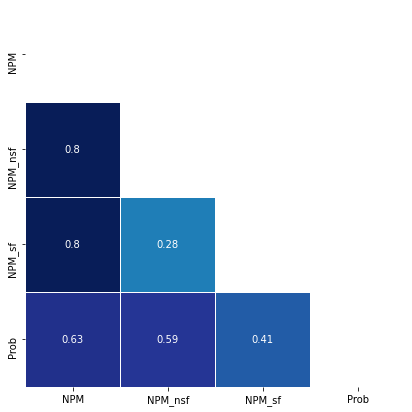

In [999]:
corr = results_npm.drop(columns=['Present']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 7))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            mask=mask,
            center=0,
            square=True,
            linewidths=1, 
            cbar=False, 
            cmap="YlGnBu", robust=False, annot=True)

(-10.0, 2010.0)

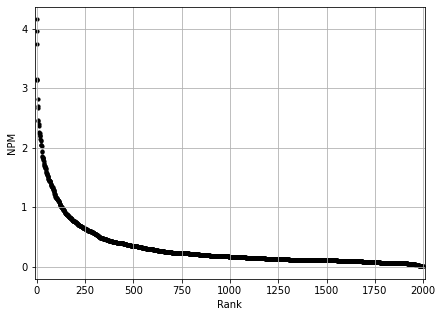

In [1000]:
x = n
combined = results_npm.groupby('Feature').mean().reset_index()  
combined = combined.sort_values(by='NPM', ascending=False).reset_index().drop(['index'], axis=1)
combined['Log_NPM'] = np.log(combined['NPM'])
plt.figure(figsize=(7, 5))
plt.grid()
plt.scatter([_ for _ in range(x)], combined['NPM'], color='black', alpha=1, s=10)
plt.xlabel('Rank')
plt.ylabel('NPM')
plt.xlim(-10, x+10)

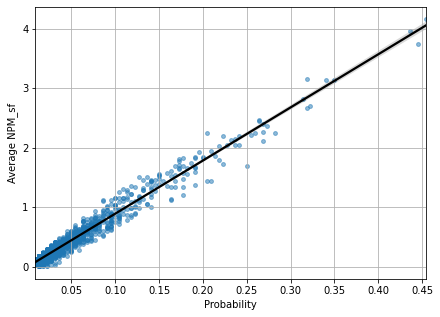

In [1001]:
plt.figure(figsize=(7, 5))
plt.scatter(combined['Prob'], combined['NPM'], alpha=0.5, s=15)
sns.regplot(data=combined, x='Prob', y='NPM', scatter=False, color='black')
plt.ylabel('Average NPM_sf')
plt.xlabel('Probability')
plt.grid()

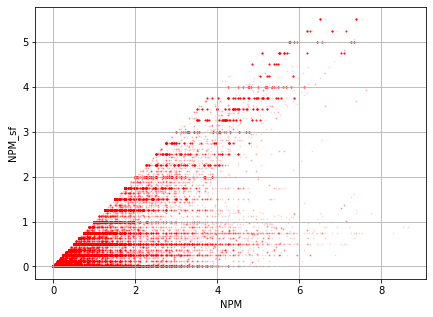

In [1002]:
plt.figure(figsize=(7, 5))
plt.scatter(results_npm['NPM'], results_npm['NPM_sf'], s=1, color='red', alpha=0.1)
plt.xlabel('NPM')
plt.ylabel('NPM_sf')
plt.grid()

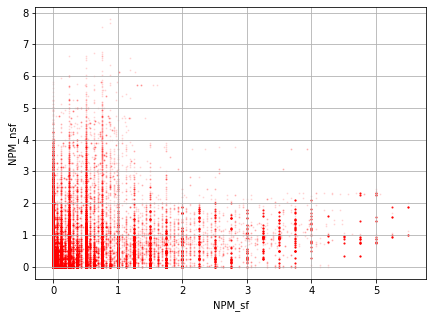

In [1003]:
plt.figure(figsize=(7, 5))
plt.scatter(results_npm['NPM_sf'], results_npm['NPM_nsf'], s=1, color='red', alpha=0.1)
plt.xlabel('NPM_sf')
plt.ylabel('NPM_nsf')
plt.grid()

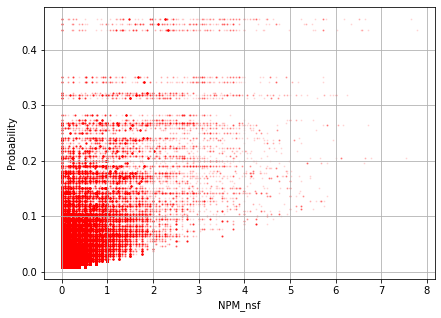

In [1004]:
plt.figure(figsize=(7, 5))
plt.scatter(results_npm['NPM_nsf'], results_npm['Prob'], s=1, color='red', alpha=0.1)
plt.xlabel('NPM_nsf')
plt.ylabel('Probability')
plt.grid()

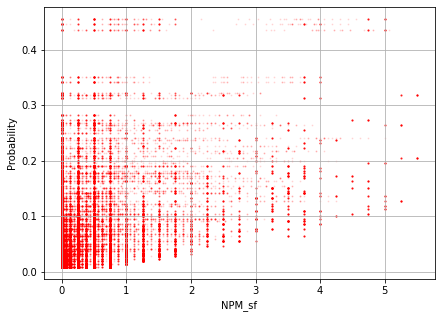

In [1005]:
plt.figure(figsize=(7, 5))
plt.scatter(results_npm['NPM_sf'], results_npm['Prob'], s=1, color='red', alpha=0.1)
plt.xlabel('NPM_sf')
plt.ylabel('Probability')
plt.grid()

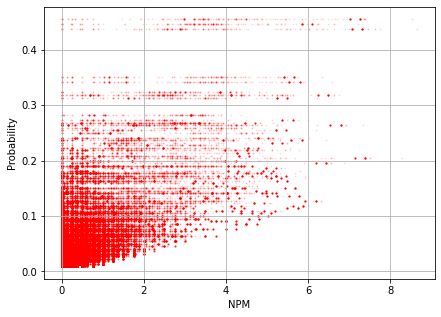

In [1006]:
plt.figure(figsize=(7, 5))
plt.scatter(results_npm['NPM'], results_npm['Prob'], s=1, color='red', alpha=0.1)
plt.xlabel('NPM')
plt.ylabel('Probability')
plt.grid()

In [1023]:
X = results_npm.drop(['Present', 'Feature', 'Language'], axis=1)
y = results_npm['Present']

Define the model:

In [1024]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
preprocessor = ColumnTransformer(transformers=[
    ('impute', 'passthrough', selector(dtype_include='float64')),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

In [1025]:
results = {}
scores = []

for subset in powerset(X.columns):
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
    scores.append(cross_validate(clf, X[subset], y, 
                                 scoring=['precision', 
                                'recall', 'f1'], cv=RepeatedKFold(n_splits=5, n_repeats=10),
                                 n_jobs=5))
    X_train, X_test, y_train, y_test = train_test_split(X[subset], y, test_size=0.33, stratify=y)
    clf.fit(X_train, y_train)
    results['+'.join(subset)] = [y_test.to_numpy(), clf.predict(X_test), recall_score(y_test, clf.predict(X_test))]

In [1026]:
print(pd.DataFrame({'Dataset': ['+'.join(_) for _ in powerset(X.columns)], 
              'f1': ['{} ({})'.format(round(np.mean(_.get('test_f1')), 3), 
                                           round(np.std(_.get('test_f1')), 3)) for _ in scores],
              'recall': ['{} ({})'.format(round(np.mean(_.get('test_recall')), 3), 
                                           round(np.std(_.get('test_recall')), 3)) for _ in scores]})\
.sort_values(by='recall', ascending=False).reset_index().drop(['index'], axis=1).to_latex(index=False))

\begin{tabular}{lll}
\toprule
                        Dataset &             f1 &         recall \\
\midrule
         NPM+NPM\_sf+Family+Prob &  0.859 (0.005) &  0.806 (0.008) \\
 NPM+NPM\_nsf+NPM\_sf+Family+Prob &  0.854 (0.005) &  0.801 (0.008) \\
     NPM\_nsf+NPM\_sf+Family+Prob &  0.856 (0.005) &    0.8 (0.007) \\
        NPM+NPM\_nsf+Family+Prob &  0.827 (0.005) &  0.762 (0.008) \\
             NPM\_sf+Family+Prob &  0.801 (0.005) &  0.721 (0.008) \\
              NPM+NPM\_sf+Family &  0.747 (0.006) &   0.65 (0.008) \\
          NPM\_nsf+NPM\_sf+Family &  0.747 (0.005) &   0.65 (0.007) \\
      NPM+NPM\_nsf+NPM\_sf+Family &  0.747 (0.006) &  0.649 (0.008) \\
                NPM+NPM\_sf+Prob &   0.71 (0.006) &  0.642 (0.009) \\
        NPM+NPM\_nsf+NPM\_sf+Prob &  0.706 (0.006) &  0.639 (0.008) \\
             NPM+NPM\_nsf+Family &  0.735 (0.006) &  0.636 (0.008) \\
            NPM\_nsf+NPM\_sf+Prob &  0.705 (0.006) &  0.635 (0.009) \\
               NPM+NPM\_nsf+Prob &  0.694 (0.0

Top-1000:

\begin{tabular}{lll}
\toprule
                        Dataset &             f1 &         recall \\
\midrule
         NPM+NPM\_sf+Family+Prob &  0.858 (0.005) &   0.81 (0.009) \\
 NPM+NPM\_nsf+NPM\_sf+Family+Prob &  0.853 (0.005) &  0.806 (0.008) \\
     NPM\_nsf+NPM\_sf+Family+Prob &  0.856 (0.004) &  0.805 (0.006) \\
        NPM+NPM\_nsf+Family+Prob &  0.822 (0.005) &   0.76 (0.007) \\
             NPM\_sf+Family+Prob &  0.797 (0.007) &    0.72 (0.01) \\
              NPM+NPM\_sf+Family &  0.764 (0.006) &   0.682 (0.01) \\
          NPM\_nsf+NPM\_sf+Family &  0.763 (0.007) &  0.681 (0.009) \\
      NPM+NPM\_nsf+NPM\_sf+Family &  0.762 (0.005) &  0.679 (0.008) \\
        NPM+NPM\_nsf+NPM\_sf+Prob &  0.727 (0.007) &  0.673 (0.012) \\
                NPM+NPM\_sf+Prob &   0.73 (0.006) &   0.673 (0.01) \\
            NPM\_nsf+NPM\_sf+Prob &  0.726 (0.007) &   0.667 (0.01) \\
             NPM+NPM\_nsf+Family &   0.75 (0.007) &  0.666 (0.009) \\
               NPM+NPM\_nsf+Prob &  0.712 (0.006) &   0.65 (0.009) \\
                  NPM\_sf+Family &  0.648 (0.009) &  0.521 (0.013) \\
                     NPM+NPM\_sf &  0.574 (0.007) &   0.513 (0.01) \\
                 NPM\_nsf+NPM\_sf &  0.573 (0.008) &   0.513 (0.01) \\
                NPM+Family+Prob &  0.611 (0.007) &  0.513 (0.008) \\
             NPM+NPM\_nsf+NPM\_sf &  0.572 (0.008) &  0.511 (0.013) \\
                    NPM+NPM\_nsf &   0.57 (0.008) &   0.51 (0.011) \\
                    NPM\_sf+Prob &  0.471 (0.017) &  0.345 (0.023) \\
                       NPM+Prob &    0.47 (0.01) &  0.345 (0.009) \\
                     NPM+Family &  0.455 (0.009) &  0.328 (0.009) \\
                            NPM &  0.214 (0.012) &  0.127 (0.009) \\
            NPM\_nsf+Family+Prob &  0.154 (0.008) &  0.098 (0.006) \\
                         NPM\_sf &  0.133 (0.009) &  0.073 (0.006) \\
                   NPM\_nsf+Prob &    0.1 (0.007) &  0.057 (0.005) \\
                    Family+Prob &  0.073 (0.006) &   0.04 (0.004) \\
                 NPM\_nsf+Family &  0.066 (0.007) &  0.036 (0.004) \\
                        NPM\_nsf &  0.017 (0.004) &  0.008 (0.002) \\
                           Prob &      0.0 (0.0) &      0.0 (0.0) \\
                         Family &      0.0 (0.0) &      0.0 (0.0) \\
\bottomrule
\end{tabular}



Top-2000:

\begin{tabular}{lll}
\toprule
                        Dataset &             f1 &         recall \\
\midrule
         NPM+NPM\_sf+Family+Prob &  0.859 (0.005) &  0.806 (0.008) \\
 NPM+NPM\_nsf+NPM\_sf+Family+Prob &  0.854 (0.005) &  0.801 (0.008) \\
     NPM\_nsf+NPM\_sf+Family+Prob &  0.856 (0.005) &    0.8 (0.007) \\
        NPM+NPM\_nsf+Family+Prob &  0.827 (0.005) &  0.762 (0.008) \\
             NPM\_sf+Family+Prob &  0.801 (0.005) &  0.721 (0.008) \\
              NPM+NPM\_sf+Family &  0.747 (0.006) &   0.65 (0.008) \\
          NPM\_nsf+NPM\_sf+Family &  0.747 (0.005) &   0.65 (0.007) \\
      NPM+NPM\_nsf+NPM\_sf+Family &  0.747 (0.006) &  0.649 (0.008) \\
                NPM+NPM\_sf+Prob &   0.71 (0.006) &  0.642 (0.009) \\
        NPM+NPM\_nsf+NPM\_sf+Prob &  0.706 (0.006) &  0.639 (0.008) \\
             NPM+NPM\_nsf+Family &  0.735 (0.006) &  0.636 (0.008) \\
            NPM\_nsf+NPM\_sf+Prob &  0.705 (0.006) &  0.635 (0.009) \\
               NPM+NPM\_nsf+Prob &  0.694 (0.008) &   0.621 (0.01) \\
                  NPM\_sf+Family &  0.652 (0.007) &  0.522 (0.008) \\
                NPM+Family+Prob &   0.62 (0.006) &  0.516 (0.008) \\
                    NPM\_sf+Prob &  0.468 (0.017) &  0.345 (0.022) \\
                       NPM+Prob &   0.467 (0.01) &  0.335 (0.009) \\
             NPM+NPM\_nsf+NPM\_sf &   0.439 (0.01) &  0.317 (0.012) \\
                 NPM\_nsf+NPM\_sf &  0.437 (0.011) &  0.316 (0.013) \\
                     NPM+NPM\_sf &  0.438 (0.012) &  0.316 (0.012) \\
                    NPM+NPM\_nsf &   0.432 (0.01) &  0.311 (0.011) \\
                     NPM+Family &  0.437 (0.011) &   0.309 (0.01) \\
                            NPM &  0.181 (0.009) &  0.104 (0.006) \\
            NPM\_nsf+Family+Prob &  0.133 (0.008) &  0.081 (0.005) \\
                         NPM\_sf &  0.112 (0.006) &  0.061 (0.003) \\
                   NPM\_nsf+Prob &  0.085 (0.005) &  0.048 (0.003) \\
                    Family+Prob &   0.06 (0.005) &  0.032 (0.003) \\
                 NPM\_nsf+Family &  0.055 (0.005) &   0.03 (0.003) \\
                        NPM\_nsf &  0.015 (0.003) &  0.008 (0.002) \\
                           Prob &      0.0 (0.0) &      0.0 (0.0) \\
                         Family &      0.0 (0.0) &      0.0 (0.0) \\
\bottomrule
\end{tabular}

## 4. Best model evaluation

In [1027]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X[['NPM',
                                                       'NPM_sf',
                                                       'Family',
                                                       'Prob']],
                                                    y, 
                                                    test_size=0.33, 
                                                    stratify=y)
clf.fit(X_train.drop(columns=['Prob', 'Family']), y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('impute', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcf90732af0>),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown=...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
         

In [1028]:
ra = roc_auc_score(y_test, clf.predict(X_test.drop(columns=['Prob', 'Family'])))

In [1029]:
rc = recall_score(y_test, clf.predict(X_test.drop(columns=['Prob', 'Family'])))

In [1030]:
pred_prob = clf.predict_proba(X_test.drop(columns=['Prob', 'Family']))[:,1]
X_test['pred_prob'] = pred_prob
X_test['pred'] = clf.predict(X_test.drop(columns=['Prob', 'Family', 'pred_prob']))
X_test['actual_v'] = y_test
X_test['prediction'] = np.where((X_test['pred'] == X_test['actual_v']), 1, 0)

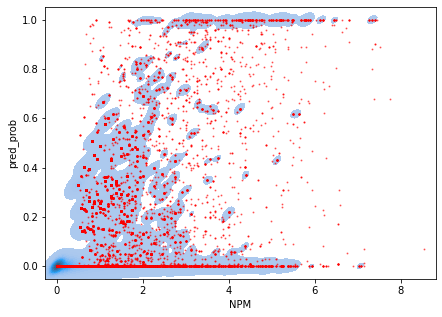

In [1031]:
plt.figure(figsize=(7, 5))
sns.kdeplot(x=X_test['NPM'], y=X_test['pred_prob'], fill=True, thresh=0.01, levels=20)
plt.scatter(X_test['NPM'], X_test['pred_prob'], s=1, color='red', alpha=0.5)

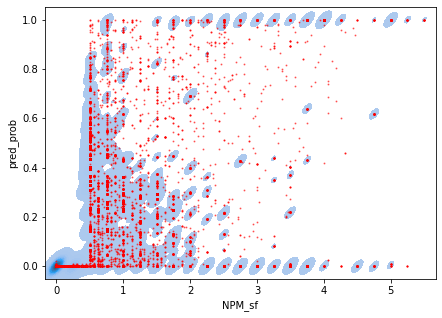

In [1032]:
plt.figure(figsize=(7, 5))
sns.kdeplot(x=X_test['NPM_sf'], y=X_test['pred_prob'], fill=True, thresh=0.01, levels=20)
plt.scatter(X_test['NPM_sf'], X_test['pred_prob'], s=1, color='red', alpha=0.5)

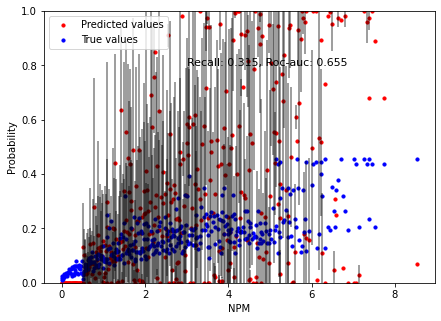

In [1033]:
avg = X_test.groupby('NPM').agg(['mean', 'std']).reset_index()
plt.figure(figsize=(7, 5))
plt.scatter(avg['NPM'], avg['pred_prob']['mean'], s=10, color='red', alpha=1, label='Predicted values')
plt.errorbar(avg['NPM'], avg['pred_prob']['mean'], avg['pred_prob']['std'], 
             linestyle='None', color='black', alpha=0.5)
plt.scatter(avg['NPM'], avg['Prob']['mean'], s=10, color='blue',
            label='True values')
plt.xlabel('NPM')
plt.ylabel('Probability')
plt.ylim(0,1)
plt.text(3, 0.8, 'Recall: {}, Roc-auc: {}'.format(round(rc, 3),
                                                  round(ra, 3)), 
         fontsize=11)
plt.legend()

In [1034]:
# plt.figure(figsize=(7, 5))
# plt.scatter(avg['NPM'], avg['Prob']['mean']-avg['pred_prob']['mean'], color='black', s=10)
# plt.axhline(y=0, ls='--', color='red')
# plt.ylim(-0.55, 0.55)

In [1067]:
avg = X_test.groupby('NPM_sf').agg(['mean', 'std']).reset_index()
plt.figure(figsize=(7, 5))
plt.scatter(avg['NPM_sf'], avg['pred_prob']['mean'], s=10, color='red', alpha=1, label='Predicted values')
plt.errorbar(avg['NPM_sf'], avg['pred_prob']['mean'], avg['pred_prob']['std'], 
             linestyle='None', color='black', alpha=0.5)
plt.scatter(avg['NPM_sf'], avg['Prob']['mean'], s=10, color='blue',
            label='True values')
plt.xlabel('NPM_sf')
plt.ylabel('Probability')
plt.ylim(0,1)
plt.text(3, 0.8, 'Recall: {}, Roc-auc: {}'.format(round(rc, 3),
                                                  round(ra, 3)), 
         fontsize=11)
plt.legend()

Text(0.02, 0.7, 'Recall: 0.315, Roc-auc: 0.655')

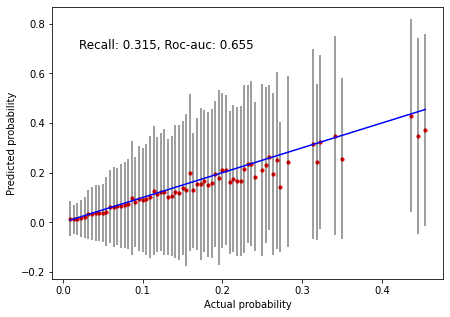

In [1036]:
avg = X_test.groupby('Prob').agg(['mean', 'std']).reset_index()

plt.figure(figsize=(7, 5))
plt.scatter(avg['Prob'], avg['pred_prob']['mean'], s=10, color='red', alpha=1)
plt.plot(avg['Prob'], avg['Prob'], color='blue', alpha=1)
plt.errorbar(avg['Prob'], avg['pred_prob']['mean'], avg['pred_prob']['std'], 
             linestyle='None', color='black', alpha=0.5)
plt.xlabel('Actual probability')
plt.ylabel('Predicted probability')
plt.text(0.02, 0.7, 'Recall: {}, Roc-auc: {}'.format(round(rc, 3), round(ra, 3)), fontsize=12)

In [1037]:
avgs = []

for _ in range(100):
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier())])

    X_train, X_test, y_train, y_test = train_test_split(X[['NPM',
                                                           'NPM_sf',
                                                           'Family',
                                                           'Prob']],
                                                        y, 
                                                        test_size=0.33, 
                                                        stratify=y)
    clf.fit(X_train.drop(columns=['Family']), y_train)
    ra = roc_auc_score(y_test, clf.predict(X_test.drop(columns=['Family'])))
    rc = recall_score(y_test, clf.predict(X_test.drop(columns=['Family'])))

    X_test['pred'] = clf.predict(X_test.drop(columns=['Family']))
    X_test['actual_v'] = y_test
    X_test['prediction'] = np.where((X_test['pred'] == X_test['actual_v']), 1, 0)
    avg = X_test[X_test['actual_v'] == 1].groupby('Family').agg(['mean'])\
    .reset_index().sort_values(('prediction', 'mean'))
    avgs.append(avg)

In [1038]:
res = pd.concat(avgs, axis=0)

res = pd.DataFrame(res.values,
              index=res.index,
              columns=res.columns.droplevel(1)).reset_index()

res['prediction'] = res['prediction'].astype(float)

avg = res[['Family', 'prediction']].groupby('Family').agg(['mean', 'std'])\
.reset_index().sort_values(('prediction', 'mean'))

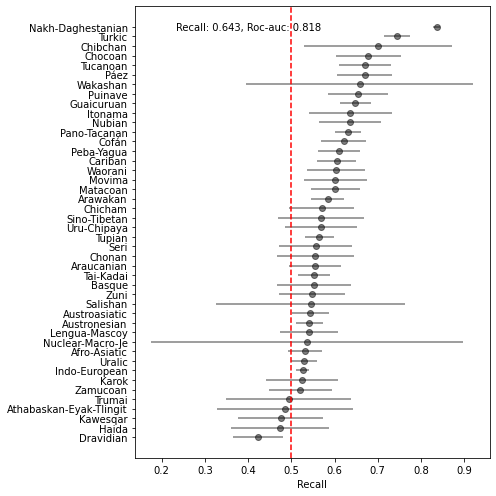

In [1065]:
plt.figure(figsize=(7, 7))
plt.scatter(avg['prediction']['mean'], 
            avg['Family'],
            color='black', 
            alpha=0.5)
plt.errorbar(x=avg['prediction']['mean'], 
             y=avg['Family'], xerr=avg['prediction']['std'],  
             linestyle='None', color='black', alpha=0.5)
plt.axvline(x=0.5, 
            ls='--', 
            color='red')
plt.xlabel('Recall')
plt.text(0.4, 43, 'Recall: {}, Roc-auc: {}'.format(round(rc, 3),
                                                  round(ra, 3)),
     horizontalalignment='center',
     verticalalignment='center')
plt.tight_layout()

In [1123]:
def get_perm_res(X=X[['NPM','Prob', 'Family']]):
    results_imp = []

    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, test_size=0.33, 
                                                            stratify=y)
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
        clf.fit(X_train, y_train)
        result = permutation_importance(clf, X_test, y_test, n_repeats=50, n_jobs=5, scoring='recall')
        sorted_idx = result.importances_mean.argsort()
        results_perm = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
        results_perm = results_perm.unstack().reset_index().drop(['level_1'], axis=1)
        results_perm.columns = ['Variable', 'Importance']
        results_imp.append(results_perm)

    results = pd.concat(results_imp, axis=0).groupby('Variable')\
    .agg(['mean', 'std']).reset_index()
    results.columns = results.columns.droplevel()
    print(results.sort_values(by='mean', ascending=False).to_latex(index=False))

In [1124]:
get_perm_res()

\begin{tabular}{lrr}
\toprule
        &      mean &       std \\
\midrule
    NPM &  0.437775 &  0.006945 \\
 Family &  0.136261 &  0.008077 \\
   Prob & -0.137536 &  0.009454 \\
\bottomrule
\end{tabular}



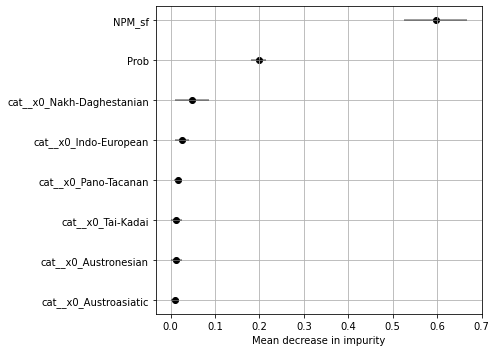

In [1106]:
X_train, X_test, y_train, y_test = train_test_split(X[['NPM_sf','Prob', 'Family']],
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
clf.fit(X_train, y_train)
importances = clf['classifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf['classifier'].estimators_], axis=0)
feature_names = get_feature_names(clf['preprocessor'].fit(X_test))
forest_importances = pd.DataFrame({'Name': feature_names, 'Importance': importances, 'sd': std})
forest_importances = forest_importances.sort_values(by='Importance', ascending=True)
forest_importances = forest_importances[forest_importances['Importance'] > 0.01]

plt.figure(figsize=(7, 5))
plt.scatter(y=forest_importances['Name'], x=forest_importances['Importance'], color='black')
plt.errorbar(y=forest_importances['Name'],
             x=forest_importances['Importance'],
             xerr=forest_importances['sd'],  
             linestyle='None', color='black', alpha=0.5)
plt.grid()
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()